In [1]:
#Import module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from collections import defaultdict
pd.options.display.float_format = '{:.2f}'.format

In [2]:
#read from web (prioritise on June)
june = [180602, 180609, 180616, 180623, 180630]
url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt'
df_list = []
for week in june:
    df_list.append(pd.read_csv(url.format(week)))
df_mta = pd.concat(df_list)

In [3]:
df_mta.dtypes

C/A                                                                     object
UNIT                                                                    object
SCP                                                                     object
STATION                                                                 object
LINENAME                                                                object
DIVISION                                                                object
DATE                                                                    object
TIME                                                                    object
DESC                                                                    object
ENTRIES                                                                  int64
EXITS                                                                    int64
dtype: object

In [4]:
print (df_mta.shape)

(983733, 11)


In [5]:
df_mta.head(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/26/2018,00:00:00,REGULAR,6633898,2248498
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/26/2018,04:00:00,REGULAR,6633916,2248500
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/26/2018,08:00:00,REGULAR,6633928,2248517
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/26/2018,12:00:00,REGULAR,6634015,2248577
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/26/2018,16:00:00,REGULAR,6634173,2248610
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/26/2018,20:00:00,REGULAR,6634367,2248645
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2018,00:00:00,REGULAR,6634496,2248662
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2018,04:00:00,REGULAR,6634503,2248664
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2018,08:00:00,REGULAR,6634514,2248675
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/27/2018,12:00:00,REGULAR,6634542,2248713


In [6]:
df_mta.tail(10)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
196680,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,06/28/2018,09:00:00,REGULAR,2953544,387653
196681,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,06/28/2018,13:00:00,REGULAR,2953874,387654
196682,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,06/28/2018,17:00:00,REGULAR,2954306,387664
196683,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,06/28/2018,21:00:00,REGULAR,2954587,387672
196684,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,06/29/2018,01:00:00,REGULAR,2954726,387680
196685,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,06/29/2018,05:00:00,REGULAR,2954731,387681
196686,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,06/29/2018,09:00:00,REGULAR,2954991,387686
196687,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,06/29/2018,13:00:00,REGULAR,2955443,387690
196688,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,06/29/2018,17:00:00,REGULAR,2955940,387696
196689,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,06/29/2018,21:00:00,REGULAR,2956334,387720


In [7]:
#Count number of people entry on each day
temp_d = defaultdict(list)
turnstile_d = {}
for row in df_mta.itertuples():
    C_A, unit, scp, station, linename, date = row[1], row[2], row[3], row[4], ''.join(sorted(row[5])), row[7]
    entries = row[10]
    k = (C_A, unit, scp, station, linename, date)
    temp_d[k].append(entries)
    
for key, value in temp_d.items():
    entry = abs(max(value) - min(value))
    turnstile_d[key] = [entry]

In [8]:
#Create an entry data frame
dict_df_entry = pd.DataFrame.from_dict(turnstile_d, orient='index')
dict_df_entry.rename(columns = {0:'Entries'}, inplace=True)
dict_df_entry.head(10)

,Entries
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 05/26/2018)",469
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 05/27/2018)",360
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 05/28/2018)",450
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 05/29/2018)",1154
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 05/30/2018)",1244
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 05/31/2018)",1297
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 06/01/2018)",1292
"(A002, R051, 02-00-01, 59 ST, 456NQRW, 05/26/2018)",411
"(A002, R051, 02-00-01, 59 ST, 456NQRW, 05/27/2018)",308
"(A002, R051, 02-00-01, 59 ST, 456NQRW, 05/28/2018)",406


In [9]:
#Count number of people exits on each day
temp_d = defaultdict(list)
turnstile_d = {}
for row in df_mta.itertuples():
    C_A, unit, scp, station, linename, date = row[1], row[2], row[3], row[4], ''.join(sorted(row[5])), row[7]
    exits = row[11]
    k = (C_A, unit, scp, station, linename, date)
    temp_d[k].append(exits)
    
for key, value in temp_d.items():
    exits = abs(max(value) - min(value))
    turnstile_d[key] = [exits]

In [10]:
#Create an exit data frame
dict_df_exits = pd.DataFrame.from_dict(turnstile_d, orient='index')
dict_df_exits.rename(columns = {0:'Exits'}, inplace=True)
dict_df_exits.head(10)

,Exits
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 05/26/2018)",147
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 05/27/2018)",114
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 05/28/2018)",143
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 05/29/2018)",526
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 05/30/2018)",553
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 05/31/2018)",521
"(A002, R051, 02-00-00, 59 ST, 456NQRW, 06/01/2018)",516
"(A002, R051, 02-00-01, 59 ST, 456NQRW, 05/26/2018)",81
"(A002, R051, 02-00-01, 59 ST, 456NQRW, 05/27/2018)",68
"(A002, R051, 02-00-01, 59 ST, 456NQRW, 05/28/2018)",94


In [11]:
#Split the df and give them column name
df_turnstile = pd.DataFrame(columns=[])
df_turnstile['C/A'] = [row[0][0] for row in dict_df_exits.itertuples()]
df_turnstile['Unit'] = [row[0][1] for row in dict_df_exits.itertuples()]
df_turnstile['SCP'] = [row[0][2] for row in dict_df_exits.itertuples()]
df_turnstile['Station'] = [row[0][3] for row in dict_df_exits.itertuples()]
df_turnstile['Linename'] = [row[0][4] for row in dict_df_exits.itertuples()]
df_turnstile['Date'] = [row[0][5] for row in dict_df_exits.itertuples()]
df_turnstile['Entries'] = [row[1] for row in dict_df_entry.itertuples()]
df_turnstile['Exits'] = [row[1] for row in dict_df_exits.itertuples()]

In [12]:
df_turnstile.head()

,C/A,Unit,SCP,Station,Linename,Date,Entries,Exits
0,A002,R051,02-00-00,59 ST,456NQRW,05/26/2018,469,147
1,A002,R051,02-00-00,59 ST,456NQRW,05/27/2018,360,114
2,A002,R051,02-00-00,59 ST,456NQRW,05/28/2018,450,143
3,A002,R051,02-00-00,59 ST,456NQRW,05/29/2018,1154,526
4,A002,R051,02-00-00,59 ST,456NQRW,05/30/2018,1244,553


In [13]:
df_turnstile.shape

(164362, 8)

In [14]:
#detecting outliers
df_turnstile.describe()

,Entries,Exits
count,164362.00,164362.00
mean,83124.58,66845.52
std,10973003.00,9203784.69
min,0.00,0.00
25%,237.00,130.00
50%,732.00,445.00
75%,1431.00,1007.00
max,2113959893.00,1838305870.00


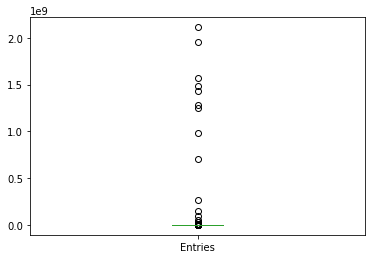

In [15]:
df_turnstile['Entries'].plot(kind = 'box')

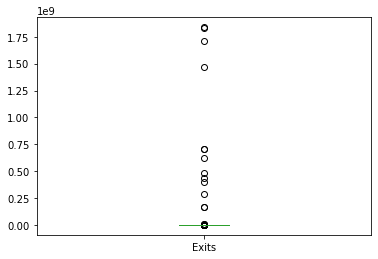

In [16]:
df_turnstile['Exits'].plot(kind = 'box')

In [17]:
#CLean outlier using IQR methods
Q1 = df_turnstile.quantile(0.25)
Q3 = df_turnstile.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Entries   1194.00
Exits      877.00
dtype: float64


In [18]:
#Check the cleaned dataframe
df_turnstile_cln = df_turnstile[~((df_turnstile < (Q1 - 1.5 * IQR)) |(df_turnstile > (Q3 + 1.5 * IQR))).any(axis=1)]
print (df_turnstile_cln.describe())
print (df_turnstile_cln.shape)

        Entries     Exits
count 151460.00 151460.00
mean     843.14    562.20
std      760.62    559.63
min        0.00      0.00
25%      200.00    107.00
50%      665.00    389.00
75%     1302.00    855.00
max     3222.00   2322.00
(151460, 8)


In [19]:
#Change the format of Date and Time to datetime
df_turnstile_cln['Date'] = pd.to_datetime(df_turnstile_cln.loc[:, 'Date'], format = '%m/%d/%Y')
print (df_turnstile_cln.dtypes)

C/A                 object
Unit                object
SCP                 object
Station             object
Linename            object
Date        datetime64[ns]
Entries              int64
Exits                int64
dtype: object


C:\Users\Yoga Pratama S\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
print (df_turnstile_cln['Station'].nunique())

377


In [21]:
print (df_turnstile_cln['Linename'].nunique())

95


In [22]:
#Group data frame by linename and station
df_line_stn = df_turnstile_cln.groupby(['Linename', 'Station']).sum()
df_line_stn_entry = df_line_stn.sort_values(by='Entries', ascending=False)
df_line_stn_entry.reset_index(inplace=True)
df_line_stn_exits = df_line_stn.sort_values(by='Exits', ascending=False)
df_line_stn_exits.reset_index(inplace=True)

In [23]:
df_line_stn_entry.head(11)

,Linename,Station,Entries,Exits
0,2345ACJZ,FULTON ST,2313577,1398749
1,ACE,34 ST-PENN STA,1872624,1412136
2,4567S,GRD CNTRL-42 ST,1807672,1225670
3,BDFMNQRW,34 ST-HERALD SQ,1415799,1284113
4,1237ACENQRSW,42 ST-PORT AUTH,1319842,848743
5,1,PATH NEW WTC,1319269,1132822
6,7,FLUSHING-MAIN,1201062,930858
7,456NQRW,59 ST,1199439,1013766
8,2345BDNQR,ATL AV-BARCLAY,1113735,778376
9,1237ACENQRSW,TIMES SQ-42 ST,1111051,962110


In [24]:
df_line_stn_exits.head(11)

,Linename,Station,Entries,Exits
0,ACE,34 ST-PENN STA,1872624,1412136
1,2345ACJZ,FULTON ST,2313577,1398749
2,BDFMNQRW,34 ST-HERALD SQ,1415799,1284113
3,4567S,GRD CNTRL-42 ST,1807672,1225670
4,1,PATH NEW WTC,1319269,1132822
5,456NQRW,59 ST,1199439,1013766
6,1237ACENQRSW,TIMES SQ-42 ST,1111051,962110
7,1ABCD,59 ST COLUMBUS,1099089,957279
8,7,FLUSHING-MAIN,1201062,930858
9,1237ACENQRSW,42 ST-PORT AUTH,1319842,848743


In [30]:
#Thanks to https://github.com/chriswhong/nycturnstiles Chriswhong
NYC_transit = 'geocoded.csv'

In [32]:
subway_location = pd.read_csv(NYC_transit, header = None, names = ['Unit', 'C/A', 'Station', 'Linename', 'Division', 'Lat', 'Lng'])
subway_location.head()

#There are minues value in duration seconds column

,Unit,C/A,Station,Linename,Division,Lat,Lng
0,R470,X002,ELTINGVILLE PK,Z,SRT,40.54,-74.16
1,R544,PTH02,HARRISON,1,PTH,40.74,-74.16
2,R165,S102,TOMPKINSVILLE,1,SRT,40.64,-74.07
3,R070,S101,ST. GEORGE,1,SRT,40.64,-74.07
4,R070,S101A,ST. GEORGE,1,SRT,40.64,-74.07


In [40]:
loc = ['Unit', 'Lat', 'Lng']
df_stat_loc = subway_location[loc]
df_stat_loc = df_stat_loc.drop_duplicates(keep = 'last')
df_stat_loc.head()

,Unit,Lat,Lng
0,R470,40.54,-74.16
1,R544,40.74,-74.16
2,R165,40.64,-74.07
4,R070,40.64,-74.07
5,R552,40.73,-74.06


In [50]:
#merge turnstile df with location
df = pd.merge(df_turnstile_cln, df_stat_loc, on='Unit', how='left')


In [52]:
df

,C/A,Unit,SCP,Station,Linename,Date,Entries,Exits,Lat,Lng
0,A002,R051,02-00-00,59 ST,456NQRW,2018-05-26,469,147,40.76,-73.97
1,A002,R051,02-00-00,59 ST,456NQRW,2018-05-27,360,114,40.76,-73.97
2,A002,R051,02-00-00,59 ST,456NQRW,2018-05-28,450,143,40.76,-73.97
3,A002,R051,02-00-00,59 ST,456NQRW,2018-05-29,1154,526,40.76,-73.97
4,A002,R051,02-00-00,59 ST,456NQRW,2018-05-30,1244,553,40.76,-73.97
...,...,...,...,...,...,...,...,...,...,...
155641,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,2018-06-25,1458,32,40.76,-73.95
155642,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,2018-06-26,1384,18,40.76,-73.95
155643,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,2018-06-27,1590,38,40.76,-73.95
155644,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,2018-06-28,1270,21,40.76,-73.95


In [60]:
#Explore with visualization
import folium
def generateBaseMap(default_location=[40.693943, -73.985880], default_zoom_start=11):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [62]:
from folium.plugins import HeatMap
base_map = generateBaseMap()
HeatMap (data=df[['Lat', 'Lng', 'Entries']].groupby(['Lat', 'Lng']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)

In [63]:
base_map

In [64]:
df_day_list = []
for day in df.Date.sort_values().unique():
    df_day_list.append(df.loc[df.Date == day, ['Lat', 'Lng', 'Entries']].groupby(['Lat', 'Lng']).sum().reset_index().values.tolist())

In [77]:
#Heatmap with day time entry
from folium.plugins import HeatMapWithTime
base_map = generateBaseMap(default_zoom_start=11)
HeatMapWithTime(df_day_list, radius=20, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)
base_map

In [70]:
#Heatmap with day time exits
df_day_list_exits = []
for day in df.Date.sort_values().unique():
    df_day_list_exits.append(df.loc[df.Date == day, ['Lat', 'Lng', 'Exits']].groupby(['Lat', 'Lng']).sum().reset_index().values.tolist())

In [76]:
base_map = generateBaseMap(default_zoom_start=11)
HeatMapWithTime(df_day_list_exits, radius=20, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)
base_map